In [1]:
import pandas as pd 
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras import Sequential 
from keras.layers import Dense, InputLayer
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras.models import load_model
tf.get_logger().setLevel('INFO')
tf.compat.v1.logging.set_verbosity('INFO')
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plot
import seaborn as sn

2021-07-24 21:24:36.420210: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
df = pd.read_csv('./dataset/shortened-sentences.csv',  
                            index_col=0,
                            names=['lang','text'])
df.index = [i for i in range(len(df))]
# df = pd.read_csv('./dataset/sentences.csv', sep='\t', 
#                             encoding='utf8', 
#                             index_col=0,
#                             names=['lang','text'])

In [3]:
LanguageList = ['eng','fra', 'spa','ita','deu']
ngramLength = 3
maxFeatures = 500
sentencePerLanguageForVocab = 1000
sentencePerLanguageForDataSet = 50000
validationSentences = 25000
testSentences = 25000

In [4]:
df = df[df['lang'].isin(LanguageList)]

In [5]:
model = load_model('./models/basic-model-shortened-sentence.model')
preprocessing_objects = pickle.load(open('./models/basic-model-shortened-sentence-preprocessing-objects.pkl','rb'))
word_vectorizer = preprocessing_objects['word_vectorizer']
langEncoder = preprocessing_objects['lang_encoder']
max_df = preprocessing_objects['max_df']
min_df = preprocessing_objects['min_df']
feature_names = word_vectorizer.get_feature_names()

2021-07-24 21:26:23.837159: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-24 21:26:23.908775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-24 21:26:23.910706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.2415GHz coreCount: 3 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 13.41GiB/s
2021-07-24 21:26:23.911009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-24 21:26:24.021945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-24 21:26:24.022192: I tensorflow/stream_executor/platfor

In [6]:
def data_generator(dataset, batch_size):
    noOfBatches = len(dataset)//batch_size
    batches = np.array_split(dataset,noOfBatches)
    i = 0
    while True:
        batch = batches[i]
        i += 1
        if i == noOfBatches:
            i = 0
        # getting x
        x = word_vectorizer.transform(batch['text'].to_list())
        xdf = pd.DataFrame(data=x.toarray(), columns=feature_names)
        xdf = (xdf - min_df)/(max_df - min_df)
        x_num = xdf.to_numpy()
    
        # getting y
        y = batch['lang'].to_list()
        y_enc = langEncoder.transform(y)
        y_num = to_categorical(y_enc, num_classes=len(LanguageList))
        yield x_num,y_num    

In [7]:
all_generator = data_generator(df, 100)
all_steps_per_epoch = len(df)//100
print(all_steps_per_epoch)

6004


In [8]:
def model_output_to_lang(outputs):
    labels = np.argmax(outputs,axis=1)
    return langEncoder.inverse_transform(labels)

In [9]:
def calculate_cf(my_model, allInput, allTarget):
    all_predictions = my_model.predict(allInput)
    test_target_lang=model_output_to_lang(allTarget)
    test_prediction_lang=model_output_to_lang(all_predictions)
    cf = confusion_matrix(test_target_lang,test_prediction_lang,labels=LanguageList)
    return cf

In [10]:
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity('ERROR')
tf.autograph.set_verbosity(3)
all_input, all_target = next(all_generator)
cf = calculate_cf(model,all_input,all_target)

2021-07-24 21:26:46.353503: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-24 21:26:46.372612: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-07-24 21:26:50.908492: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-24 21:26:51.275250: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [11]:
for i in range(all_steps_per_epoch - 1):
    print('=',end='')
    curr_input,curr_target = next(all_generator)
    cf += calculate_cf(model,curr_input, curr_target)
    if i%100 == 0:
        print("{0} done".format(i))

=0 done
====================================================================================================100 done
====================================================================================================200 done
====================================================================================================300 done
====================================================================================================400 done
====================================================================================================500 done
====================================================================================================600 done
====================================================================================================700 done
====================================================================================================800 done
====================================================================================================900 done
===========

In [14]:
cf

array([[114161,    688,    370,    374,    690],
       [   570, 120211,    774,    833,    771],
       [   336,    440, 117020,   1678,    544],
       [   202,    207,    690, 105206,    232],
       [   805,    313,    244,    274, 132835]])

In [15]:
print(np.sum(cf))
print(np.trace(cf))
print((np.sum(cf) - np.trace(cf))/np.sum(cf))
print(np.sum(cf) - np.trace(cf))

600468
589433
0.018377332347435667
11035


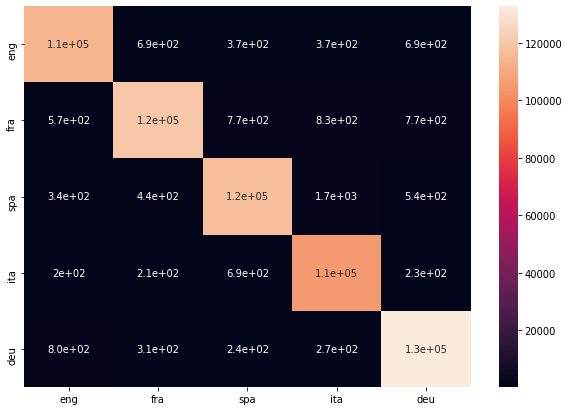

In [16]:
cf_df = pd.DataFrame(data=cf,columns=LanguageList,index=LanguageList)
plot.figure(figsize = (10,7))
sns_plot = sn.heatmap(cf_df, annot=True)

In [17]:
sns_plot.figure.savefig('./outputs/basic-model-shortened-sentence.png')